In [3]:
!pip install tensorflow

**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

**Dataset Loading through Kaggle**

In [2]:
!pip install -U Kaggle
!pip install -U imbalanced-learn
!kaggle datasets download -d kshitij192/cars-image-dataset
!unzip -q cars-image-dataset.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1
Dataset URL: https://www.kaggle.com/datasets/kshitij192/cars-image-dataset
License(s): GPL-2.0
 69% 25.0M/36.3M [00:00<00:00, 79.7MB/s]
100% 36.3M/36.3M [00:00<00:00, 89.2MB/s]


# **DATASET**

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Cars Dataset',
    image_size=(180, 180),
    batch_size=32
)

Found 4165 files belonging to 2 classes.


# **TRAIN DATASET**

In [3]:
# Loading training dataset from directory with image size = 180x180 pixels and batch size=32.
dataset_train= tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Cars Dataset/train',
    image_size=(180, 180),
    batch_size=32
)

# Initialize an empty list to store selected image paths for training.
selected_images_train = []

# Loop through each class name in the dataset's class names and elect the first 75 images from the sorted list to reduce the dataset size for training.
for class_name in dataset_train.class_names:
    class_dir = os.path.join('/content/Cars Dataset/train', class_name)
    image_paths = [os.path.join(class_dir, filename) for filename in os.listdir(class_dir)]
    image_paths.sort()
    for i, image_path in enumerate(image_paths):
        if i < 75:
            selected_images_train.append(image_path)
        else:
            break

# Load the selected images and resizing the images to 180x180 pixels.
selected_images_train = [tf.keras.preprocessing.image.load_img(image_path, target_size=(180, 180)) for image_path in selected_images_train]

# Converting the loaded images to numpy arrays.
selected_images_train = [tf.keras.preprocessing.image.img_to_array(image) for image in selected_images_train]

# Converting the list of numpy arrays into a single tensor.
images_tensor_train = tf.convert_to_tensor(selected_images_train, dtype=tf.float32)

# Creating labels for each image tensor based on its position, each class has exactly 75 images.
labels_tensor_train = tf.convert_to_tensor([i // 75 for i in range(525)], dtype=tf.int64)

# Creating TensorFlow dataset from the image and label tensors.
dataset_train = tf.data.Dataset.from_tensor_slices((images_tensor_train, labels_tensor_train))

# Shuffle the dataset and organize it into batches.
dataset_train = dataset_train.shuffle(buffer_size=1000).batch(32)

Found 3352 files belonging to 7 classes.


TRAIN DATASET


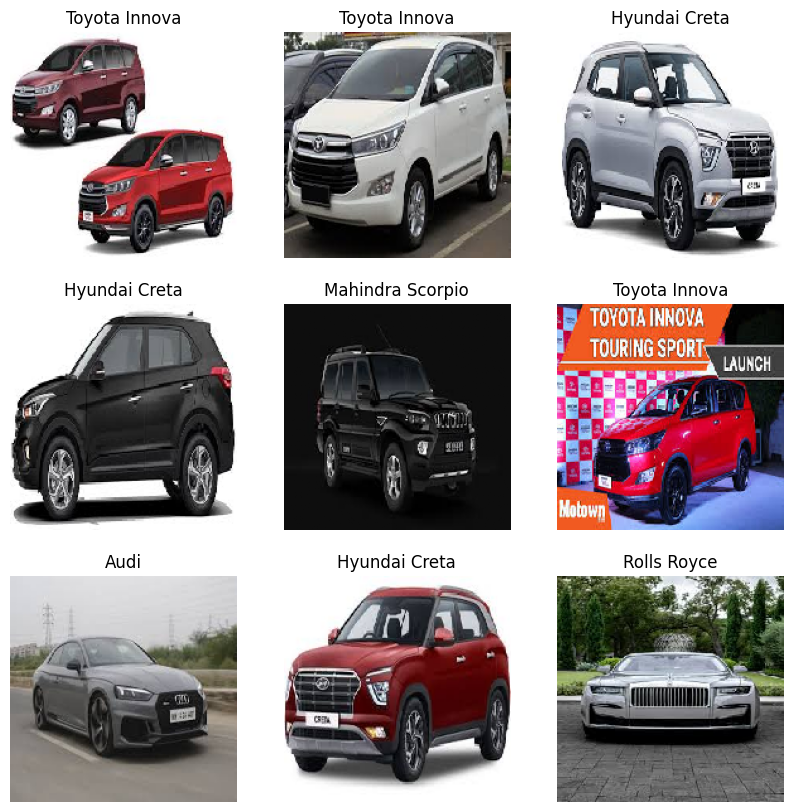

In [ ]:
# Plotting the train dataset using matplotlib library
class_names = ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']
def show_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i] / 255.0)
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
print("TRAIN DATASET")
for images, labels in dataset_train.take(1):
    show_images(images, labels, class_names)
plt.show()

# **TEST DATASET**

In [4]:
#Testing data load same as Training data and 20 images from each class.
dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Cars Dataset/test',
    image_size=(180, 180),
    batch_size=32
)

selected_images_test = []

for class_name in dataset_test.class_names:
    class_dir = os.path.join('/content/Cars Dataset/test', class_name)
    image_paths = [os.path.join(class_dir, filename) for filename in os.listdir(class_dir)]
    image_paths.sort()
    for i, image_path in enumerate(image_paths):
        if i < 20:
            selected_images_test.append(image_path)
        else:
            break

selected_images_test = [tf.keras.preprocessing.image.load_img(image_path, target_size=(180, 180)) for image_path in selected_images_test]

selected_images_test = [tf.keras.preprocessing.image.img_to_array(image) for image in selected_images_test]

images_tensor_test = tf.convert_to_tensor(selected_images_test, dtype=tf.float32)

labels_tensor_test = tf.convert_to_tensor([i // 20 for i in range(140)], dtype=tf.int64)

dataset_test = tf.data.Dataset.from_tensor_slices((images_tensor_test, labels_tensor_test))

dataset_test = dataset_test.shuffle(buffer_size=1000).batch(32)


Found 813 files belonging to 7 classes.


TEST DATASET


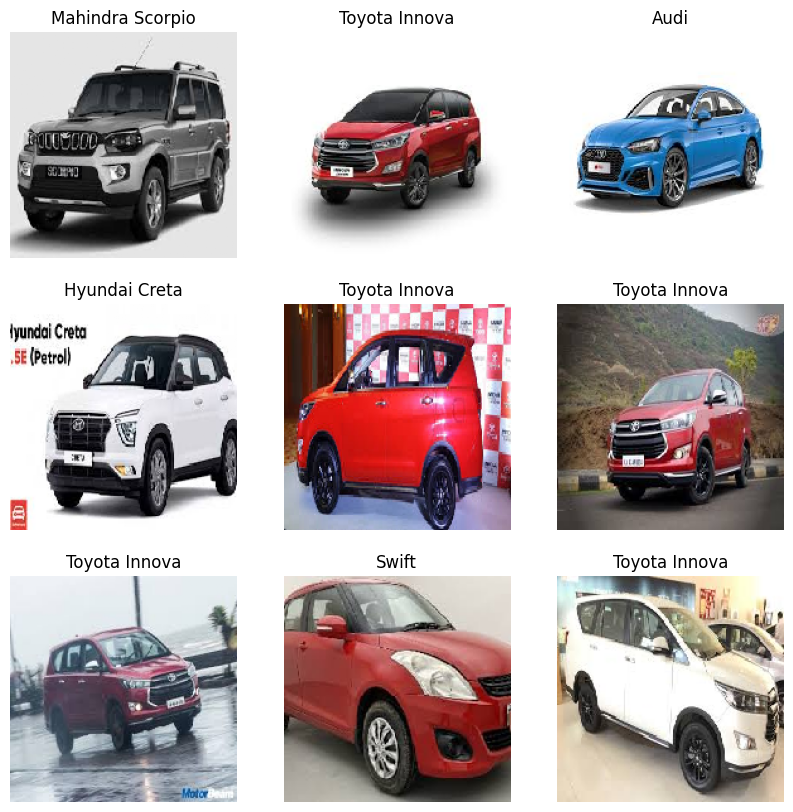

In [ ]:
#Plotting Testing Data
class_names = ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']
def show_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i] / 255.0)
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
print("TEST DATASET")
for images, labels in dataset_test.take(1):
    show_images(images, labels, class_names)

plt.show()

# **1. Preprocessed Dataset**

In [5]:
#Function to convert image into grayscale (reducing dimensionality from 3 to 1 channel). The function returns grayscale image and its label
def convert_to_grayscale(image, label):
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

Preprocessed Dataset


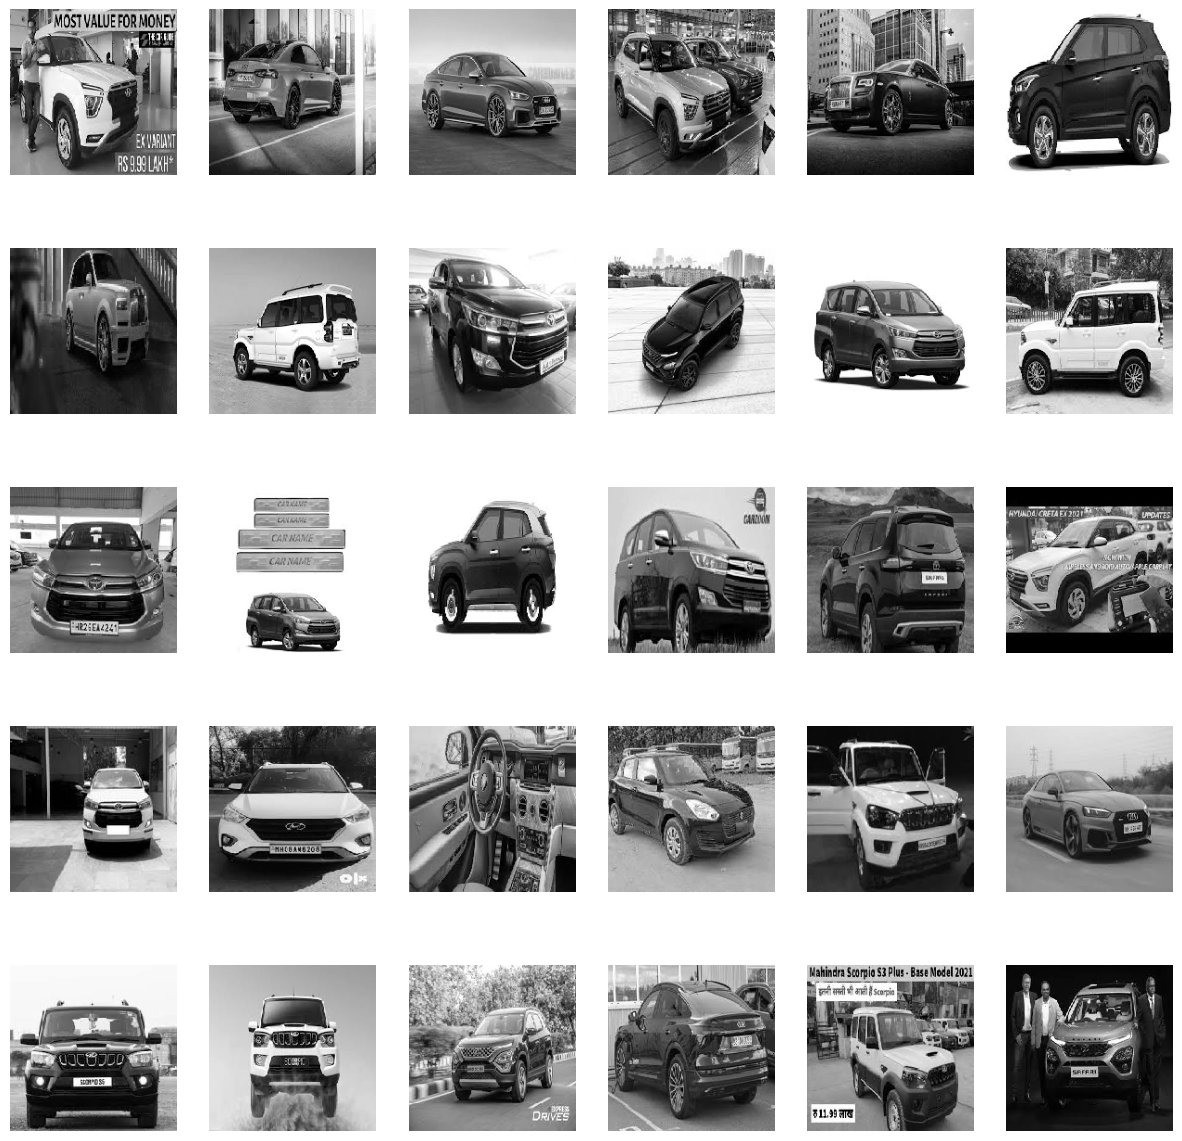

In [6]:
# This step will divide each pixel in the image by 255, scaling the pixel values to a range of 0 to 1.
normalization_layer = tf.keras.layers.Rescaling(1./255)

# This step will convert the rgb image into grayscale
grayscale = dataset_train.map(convert_to_grayscale)

# This step will normalize the grayscale images
preprocessed_dataset = grayscale.map(lambda x, y: (normalization_layer(x), y))

#ploting preprocessed dataset.
print("Preprocessed Dataset")
for images, labels in preprocessed_dataset.take(1):
    plt.figure(figsize=(15, 15))
    for i in range(30):
        ax = plt.subplot(5, 6, i + 1)
        plt.imshow(tf.squeeze(images[i]).numpy(), cmap='gray')
        plt.axis("off")
plt.show()

# **2. Data Visualisation**

# **1.Bar Plot**

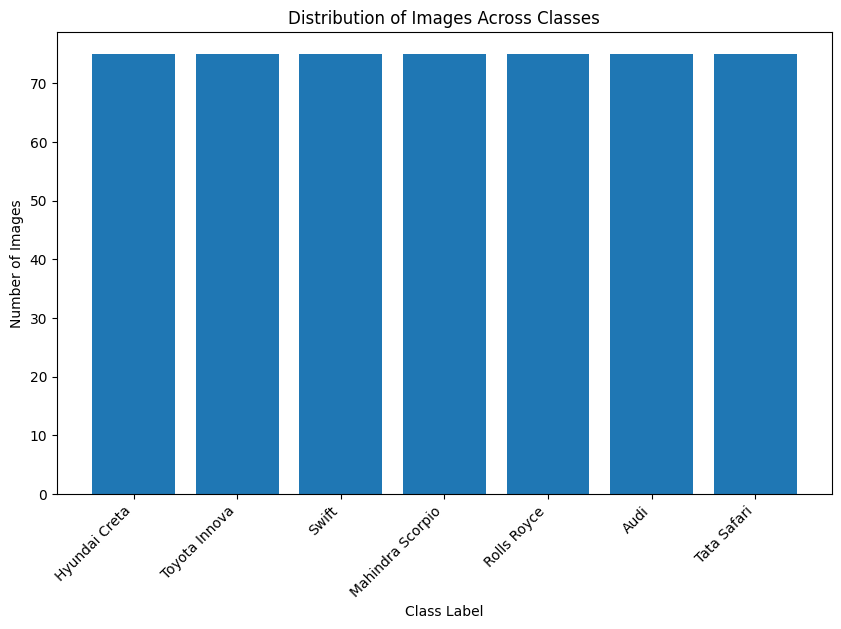

In [ ]:
class_names =  ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']

class_counts = {}
for _, labels in preprocessed_dataset:
    for label in labels.numpy():
        class_name = class_names[label]
        if class_name not in class_counts:
            class_counts[class_name] = 0
        class_counts[class_name] += 1

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
plt.xticks(rotation=45, ha='right')
plt.show()

# **2.Histogram**

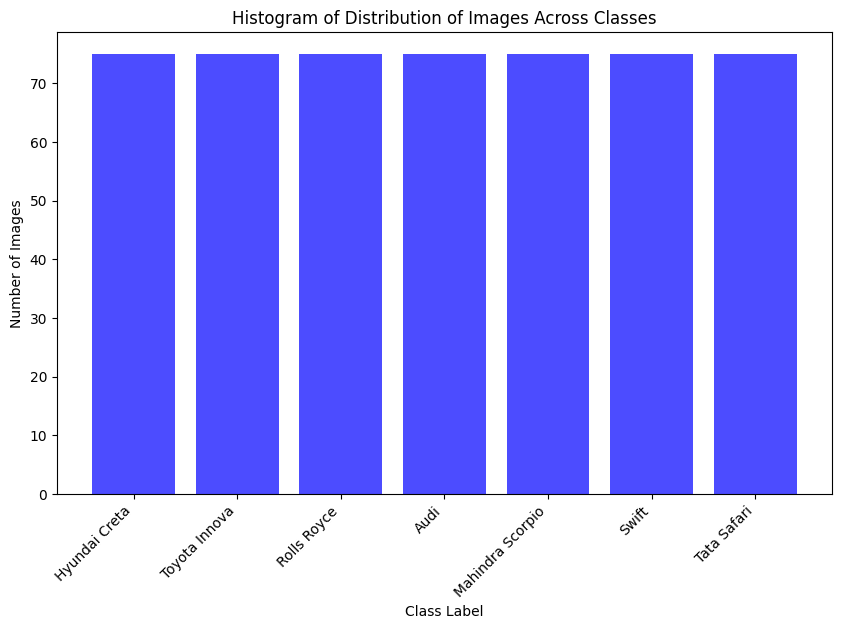

In [ ]:
class_names = ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']

class_counts = {}
for _, labels in preprocessed_dataset:
    for label in labels.numpy():
        class_name = class_names[label]
        if class_name not in class_counts:
            class_counts[class_name] = 0
        class_counts[class_name] += 1

class_labels = list(class_counts.keys())
class_sizes = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_sizes, color='blue', alpha=0.7)
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Histogram of Distribution of Images Across Classes')
plt.xticks(rotation=45, ha='right')
plt.show()


# **3.Scatter plot**

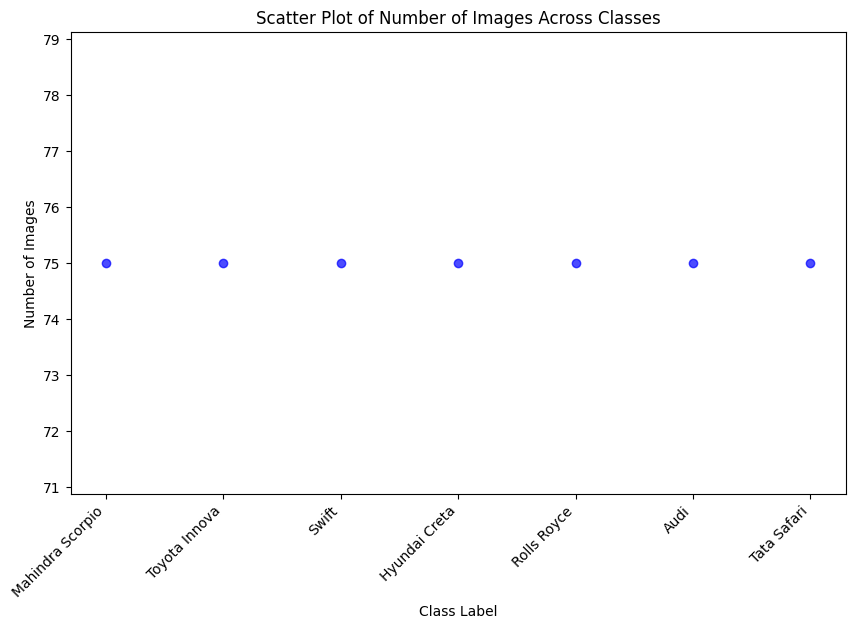

In [ ]:
class_names = ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']
class_counts = {}
for _, labels in preprocessed_dataset:
    for label in labels.numpy():
        class_name = class_names[label]
        if class_name not in class_counts:
            class_counts[class_name] = 0
        class_counts[class_name] += 1

class_labels = list(class_counts.keys())
class_values = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.scatter(class_labels, class_values, color='blue', alpha=0.7)
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Scatter Plot of Number of Images Across Classes')
plt.xticks(rotation=45, ha='right')
plt.show()


# **4.Pie Chart**

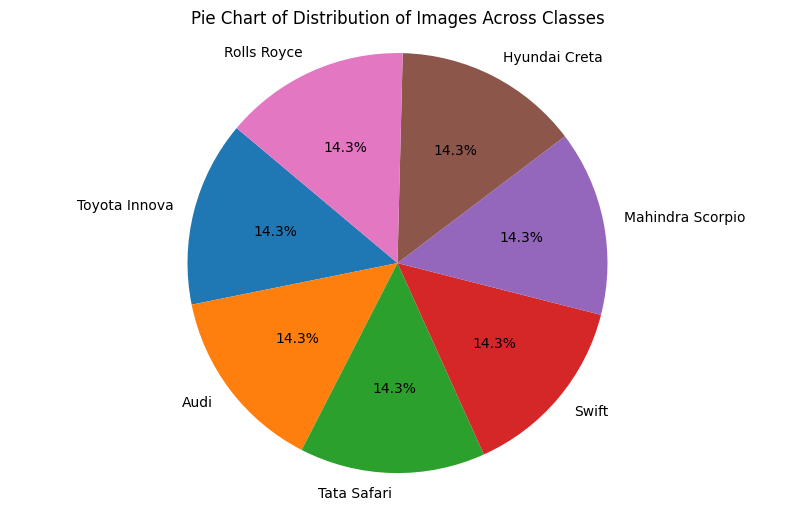

In [ ]:
class_names =  ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']

class_counts = {}
for _, labels in preprocessed_dataset:
    for label in labels.numpy():
        class_name = class_names[label]
        if class_name not in class_counts:
            class_counts[class_name] = 0
        class_counts[class_name] += 1

class_labels = list(class_counts.keys())
class_sizes = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.pie(class_sizes, labels=class_labels, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Distribution of Images Across Classes')
plt.axis('equal')
plt.show()


# **5. Line Plot**

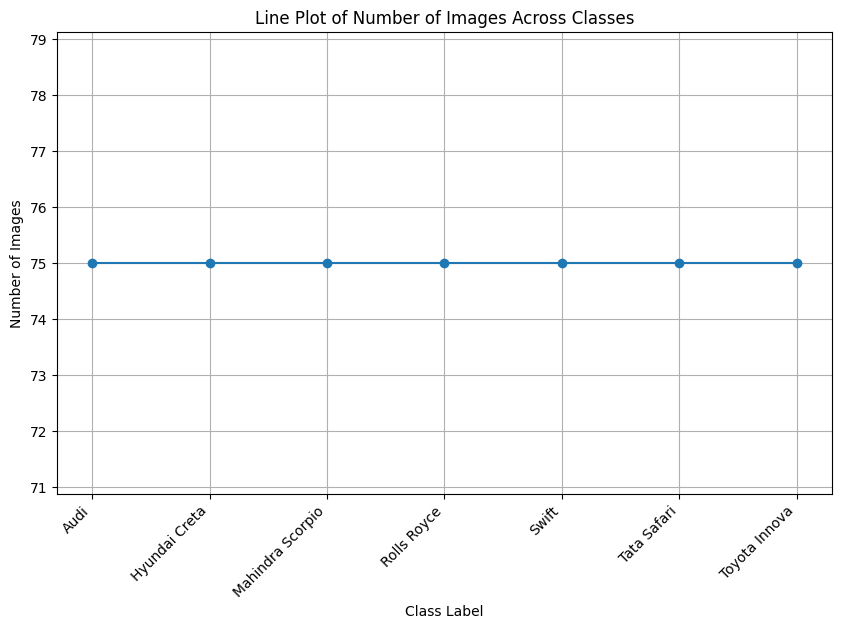

In [ ]:
class_names =  ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']
class_counts = {}
for _, labels in preprocessed_dataset:
    for label in labels.numpy():
        class_name = class_names[label]
        if class_name not in class_counts:
            class_counts[class_name] = 0
        class_counts[class_name] += 1

sorted_class_counts = {class_name: class_counts[class_name] for class_name in class_names}
class_labels = list(sorted_class_counts.keys())
class_sizes = list(sorted_class_counts.values())

plt.figure(figsize=(10, 6))
plt.plot(class_labels, class_sizes, marker='o', linestyle='-')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Line Plot of Number of Images Across Classes')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()


# **3. Checking Class Imbalancement (Training data)**

In [ ]:
class_counts_train = {}
for images, labels in dataset_train:
    for label in labels.numpy():
      # Count each label occurrence initialize to 0 if the label hasn't been encountered yet.
        class_counts_train[label] = class_counts_train.get(label, 0) + 1

# Determine the count of the most frequent class in the dataset.
majority_class_count_train = max(class_counts_train.values())

# Determine the count of the least frequent class in the dataset.
minority_class_count_train = min(class_counts_train.values())

# Calculate the imbalance ratio by dividing the count of the most frequent class by the count of the least frequent class.
imbalance_ratio_train = majority_class_count_train / minority_class_count_train

print("Class Imbalance Ratio (Training Dataset):", imbalance_ratio_train)


Class Imbalance Ratio (Training Dataset): 1.0


**TEST TRAIN SPLIT**

In [9]:
def dataset_to_numpy(dataset):
    images = []
    labels = []

# Unbatch the dataset to iterate over image and return a tuple of numpy arrays containing all images and labels.
    for image, label in dataset.unbatch():
#converting each image to numpy arrays of shape (180, 180, 1)
        images.append(tf.reshape(image, (180, 180, 1)).numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

# Convert the test data into grayscale and normalising it into the range [0, 1].
dataset_test = dataset_test.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
normalized_test_dataset = dataset_test.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))

# Converting the preprocessed training and test datasets to numpy arrays.
X_train, y_train = dataset_to_numpy(preprocessed_dataset)
X_test_original, y_test_original = dataset_to_numpy(normalized_test_dataset)


# **5. Image Classification Models**

**1.MLP Model**

In [ ]:
# Reshaping the training and testing data to automate calculation of the number of images
X_train = X_train.reshape((-1, 180, 180, 1))
X_test_original = X_test_original.reshape((-1, 180, 180, 1))

# MLP model
model = Sequential([
    Flatten(input_shape=(180, 180, 1)),
    Dense(128, activation='relu'),     #1st dense layer with 128 neurons and RELU
    Dense(64, activation='relu'),      #2nd dense layer with 64 neurons and RELU
    Dense(len(np.unique(y_train)), activation='softmax') # Output layer with a number of neurons equal to number of unique labels, using softmax for multiclass classification.
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# creating tensforflow training and test dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test_original, y_test_original)).batch(32)

# Training the model with 10 epochs
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Evaluating the model on the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_original, y_test_original)).batch(32)
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# predictions using test dataset
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

#classification report
print(classification_report(y_test_original, y_pred_classes, target_names=['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']))

#confusion matrix
cm = confusion_matrix(y_test_original, y_pred_classes)

#sensitivity and specificity for each class
sensitivity = []
specificity = []
for i in range(len(cm)):
    tp = cm[i, i]
    fn = np.sum(cm[i, :]) - tp
    fp = np.sum(cm[:, i]) - tp
    tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + tp
    sensitivity.append(tp / (tp + fn) if (tp + fn) != 0 else 0)
    specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
    print(f"Class {i} - {['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova'][i]} Sensitivity: {sensitivity[-1]:.2f}, Specificity: {specificity[-1]:.2f}")


Epoch 1/10
14/14 [==============================] - 1s 15ms/step - loss: 9.5280 - accuracy: 0.1214 - val_loss: 3.3988 - val_accuracy: 0.1500
Epoch 2/10
14/14 [==============================] - 0s 6ms/step - loss: 2.7754 - accuracy: 0.2238 - val_loss: 3.1176 - val_accuracy: 0.1500
Epoch 3/10
14/14 [==============================] - 0s 6ms/step - loss: 2.2112 - accuracy: 0.2381 - val_loss: 2.7433 - val_accuracy: 0.1714
Epoch 4/10
14/14 [==============================] - 0s 6ms/step - loss: 2.2320 - accuracy: 0.2619 - val_loss: 2.6674 - val_accuracy: 0.2143
Epoch 5/10
14/14 [==============================] - 0s 6ms/step - loss: 1.9905 - accuracy: 0.3310 - val_loss: 2.3037 - val_accuracy: 0.2429
Epoch 6/10
14/14 [==============================] - 0s 6ms/step - loss: 1.8899 - accuracy: 0.3952 - val_loss: 3.0485 - val_accuracy: 0.2214
Epoch 7/10
14/14 [==============================] - 0s 6ms/step - loss: 1.7929 - accuracy: 0.3690 - val_loss: 3.0733 - val_accuracy: 0.2000
Epoch 8/10
14/14 [=

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**2. CNN MODEL**

Epoch 1/10
14/14 [==============================] - 2s 32ms/step - loss: 2.0488 - accuracy: 0.1524 - val_loss: 1.9428 - val_accuracy: 0.1643
Epoch 2/10
14/14 [==============================] - 0s 22ms/step - loss: 1.9431 - accuracy: 0.1548 - val_loss: 1.9306 - val_accuracy: 0.2071
Epoch 3/10
14/14 [==============================] - 0s 22ms/step - loss: 1.8584 - accuracy: 0.3071 - val_loss: 2.0460 - val_accuracy: 0.2071
Epoch 4/10
14/14 [==============================] - 0s 22ms/step - loss: 1.6099 - accuracy: 0.4524 - val_loss: 2.5862 - val_accuracy: 0.2071
Epoch 5/10
14/14 [==============================] - 0s 22ms/step - loss: 1.1441 - accuracy: 0.6357 - val_loss: 1.9128 - val_accuracy: 0.3500
Epoch 6/10
14/14 [==============================] - 0s 22ms/step - loss: 0.6794 - accuracy: 0.7786 - val_loss: 2.0167 - val_accuracy: 0.3286
Epoch 7/10
14/14 [==============================] - 0s 22ms/step - loss: 0.2815 - accuracy: 0.9429 - val_loss: 2.5421 - val_accuracy: 0.3500
Epoch 8/10
14

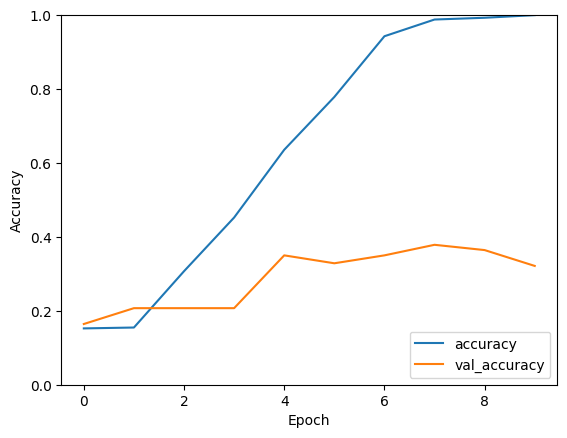

In [ ]:
#The Cnn model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 1)), # 1st convolution layer with 32 filters
    MaxPooling2D((2, 2)),  #1st pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # 2nd convolution layer with depth=64
    MaxPooling2D((2, 2)), # 2nd pooling layer
    Conv2D(64, (3, 3), activation='relu'), # 3rd convolution layer, maintaining depth at 64
    Flatten(), # Flatten the output
    Dense(64, activation='relu'), # Dense layer
    Dense(len(np.unique(y_train)), activation='softmax')  # Output layer with a softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# creating tensforflow training and test dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test_original, y_test_original)).batch(32)

# Training the model with 10 epochs
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Evaluating the model on the test dataset
test_loss, test_accuracy = model.evaluate(val_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# predictions using test dataset
y_pred = model.predict(val_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

#classification report
print(classification_report(y_test_original, y_pred_classes, target_names=['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']))

#confusion matrix
cm = confusion_matrix(y_test_original, y_pred_classes)

#sensitivity and specificity for each class
sensitivity = []
specificity = []
for i in range(len(cm)):
    tp = cm[i, i]
    fn = np.sum(cm[i, :]) - tp
    fp = np.sum(cm[:, i]) - tp
    tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + tp
    sensitivity.append(tp / (tp + fn) if (tp + fn) != 0 else 0)
    specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
    print(f"Class {i} - {['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova'][i]} Sensitivity: {sensitivity[-1]:.2f}, Specificity: {specificity[-1]:.2f}")

# Ploting the training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

**TEST TRAIN DATA WITH DATA AUGMENTATION**

In [7]:
# It applies three augmentation techniques to the images:
#random horizontal flipping,
#random rotations by up to 20% of 360 degrees (both clockwise and counterclockwise),
#and random zooming by up to 20%.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

def preprocess_and_augment(image, label):
    image = data_augmentation(image)
    return image, label

#applying augmentation on preproceesed train data
augmented_train_dataset = preprocessed_dataset.map(preprocess_and_augment)

# Same as above test train split
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image, label in dataset.unbatch():
        images.append(tf.reshape(image, (180, 180, 1)).numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

dataset_test = dataset_test.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
normalized_test_dataset = dataset_test.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))
normalized_test_dataset=normalized_test_dataset.map(preprocess_and_augment)

X_train, y_train = dataset_to_numpy(augmented_train_dataset)
X_test_original, y_test_original = dataset_to_numpy(normalized_test_dataset)



**3. VGG Model (Transfer Learning)**

Original X_train shape: (525, 180, 180, 1)
Original X_test_original shape: (140, 180, 180, 1)
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
17/17 [==============================] - 258s 15s/step - loss: 2.4881 - accuracy: 0.1733 - val_loss: 1.7650 - val_accuracy: 0.3500
Epoch 2/10
17/17 [==============================] - 287s 17s/step - loss: 1.2288 - accuracy: 0.5886 - val_loss: 1.5992 - val_accuracy: 0.3714
Epoch 3/10
17/17 [==============================] - 283s 17s/step - loss: 0.6974 - accuracy: 0.8362 - val_loss: 1.5000 - val_accuracy: 0.4143
Epoch 4/10
17/17 [==============================] - 288s 17s/step - loss: 0.3305 - accuracy: 0.9752 - val_loss: 1.5103 - val_accuracy: 0.4357
Epoch 5/10
17/17 [==============================] - 256s 15s/step - loss: 0.1518 - accuracy: 0.9981 - val_loss: 1.5171 - val_accuracy: 0.5000
Epoch 6/10
17/17 [==============================] - 255s 15s/step - loss: 0.0720 - accuracy: 1.0000 - val_loss: 1.4592 - val_accura

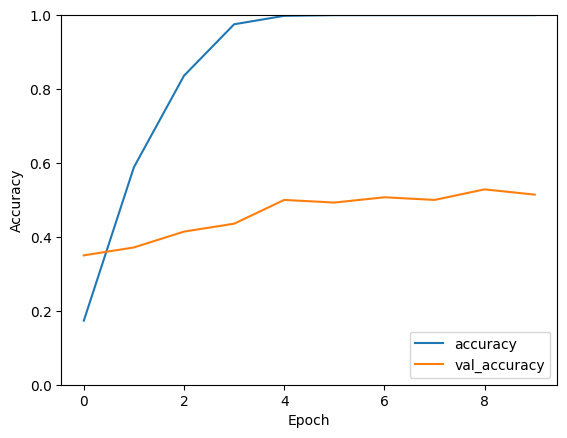


Sensitivity by Class:
Class Audi: 0.40
Class Hyundai Creta: 0.80
Class Mahindra Scorpio: 0.55
Class Rolls Royce: 0.60
Class Swift: 0.50
Class Tata Safari: 0.35
Class Toyota Innova: 0.40

Specificity by Class:
Class Audi: 0.95
Class Hyundai Creta: 0.87
Class Mahindra Scorpio: 0.95
Class Rolls Royce: 0.92
Class Swift: 0.93
Class Tata Safari: 0.91
Class Toyota Innova: 0.91


In [8]:
# Function to expand grayscale images to RGB
def gray_to_rgb(images):
    return np.repeat(images, 3, axis=-1)

# Printing X_train and X_test_original shapes
print("Original X_train shape:", X_train.shape)
print("Original X_test_original shape:", X_test_original.shape)

# Converting grayscale images to RGB by duplicating the single channel
X_train_rgb = gray_to_rgb(X_train)
X_test_original_rgb = gray_to_rgb(X_test_original)

# Scaling the RGB images
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_rgb.reshape(-1, 180 * 180 * 3))
X_test_scaled = scaler.transform(X_test_original_rgb.reshape(-1, 180 * 180 * 3))

# Reshaping back to the original image dimensions
X_train_scaled_reshaped = X_train_scaled.reshape(-1, 180, 180, 3)
X_test_scaled_reshaped = X_test_scaled.reshape(-1, 180, 180, 3)

input_shape = (180, 180, 3)
class_names = ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']

# Setting up the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

# Adding custom layers on top of the base model
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = Flatten()(x) # Flatten the output to convert it into a 1D array.
x = Dense(128, activation='relu')(x) # 1st dense layer with 128 neurons and ReLU
outputs = Dense(len(class_names), activation='softmax')(x) # Output layer with number of neurons equal to number of unique labels, using softmax for multiclass classification.
model = Model(inputs, outputs)

# Compiling the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled_reshaped, y_train, epochs=10, validation_data=(X_test_scaled_reshaped, y_test_original))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled_reshaped, y_test_original)
print("Test Accuracy:", test_accuracy)

y_pred_probabilities = model.predict(X_test_scaled_reshaped)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_original, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test_original, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Calculating sensitivity and specificity
sensitivity_per_class = {}
specificity_per_class = {}
for i, class_name in enumerate(class_names):
    TP = cm[i, i]
    FN = sum(cm[i, :]) - TP
    FP = sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    sensitivity_per_class[class_name] = TP / (TP + FN) if TP + FN > 0 else 0
    specificity_per_class[class_name] = TN / (TN + FP) if TN + FP > 0 else 0

print("\nSensitivity by Class:")
for cls, sens in sensitivity_per_class.items():
    print(f"Class {cls}: {sens:.2f}")

print("\nSpecificity by Class:")
for cls, spec in specificity_per_class.items():
    print(f"Class {cls}: {spec:.2f}")


# **6/7 Models With Hyper Parameters**

**MLP with hyper parameters tuned**

In [ ]:
def flatten_images(images):
    return images.reshape(images.shape[0], -1)  # Reshaping images from (n, 180, 180, 1) to (n, 32400)

# Flatten the training and test datasets
X_train_flat = flatten_images(X_train)
X_test_flat = flatten_images(X_test_original)


In [ ]:
#parameter grid for hyperparameter tuning.
param_grid = {
    'hidden_layer_sizes': [(128,), (200,)], #size of hidden layers
    'activation': ['relu', 'tanh'],  # Activation functions
    'alpha': [0.001],  # Regularization strength to reduce overfitting.
    'batch_size': [32],  # Batch size for mini-batch training
    'max_iter': [100]  # Maximum number of iterations or epochs
}

MLPClassifier
mlp = MLPClassifier(random_state=1)

# GridSearchCV Setup
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=2, verbose=2)
grid_search.fit(X_train_flat, y_train)

# Printing the best parameters and the best cross-validation score
print("Best parameters found:\n", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Prediction on test data
y_pred = grid_search.predict(X_test_flat)
print("\nClassification Report:\n", classification_report(y_test_original, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test_original, y_pred)
print("\nConfusion Matrix:\n", cm)

# Calculating sensitivity and specificity for each class
sensitivity_per_class = []
specificity_per_class = []
for i in range(len(cm)):
    tp = cm[i, i]
    fn = sum(cm[i, :]) - tp
    fp = sum(cm[:, i]) - tp
    tn = cm.sum() - (tp + fp + fn + sum(cm[:, i]) - tp)
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    print(f"Class {i} - Sensitivity (Recall): {sensitivity:.2f}, Specificity: {specificity:.2f}")

# Evaluating the model on the test data
print("Validation set score: {:.2f}".format(grid_search.score(X_test_flat, y_test_original)))


Fitting 2 folds for each of 4 candidates, totalling 8 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), max_iter=100; total time=  42.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), max_iter=100; total time=  40.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(200,), max_iter=100; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(200,), max_iter=100; total time= 1.1min
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), max_iter=100; total time=  11.3s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), max_iter=100; total time=  10.8s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(200,), max_iter=100; total time=  16.6s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(200,), max_iter=100; total time=  21.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found:
 {'activation': 'relu', 'alpha': 0.001, 'batch_size': 32, 'hidden_layer_sizes': (200,), 'max_iter': 100}
Best cross-validation score: 0.28

Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.20      0.16        20
           1       0.15      0.10      0.12        20
           2       0.18      0.15      0.16        20
           3       0.16      0.20      0.18        20
           4       0.18      0.15      0.16        20
           5       0.29      0.20      0.24        20
           6       0.16      0.20      0.18        20

    accuracy                           0.17       140
   macro avg       0.18      0.17      0.17       140
weighted avg       0.18      0.17      0.17       140


Confusion Matrix:
 [[4 3 3 3 3 1 3]
 [4 2 5 3 4 1 1]
 [2 4 3 1 5 1 4]
 [6 1 2 4 0 2 5]
 [3 1 0 6 3 1 6]
 [4 1 4 4 1 4 2]
 [6 1 0 4 1 4 4]]
Class 0 - Sensitivity (Recall): 0.20, Specificity: 0.74
Class 1 - Sensitivit

**CNN Hyperparameters tuned**


In [ ]:
#creating cnn model just like simple cnn model
def create_cnn_model(filters, kernel_size, activation, dropout_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, input_shape=(180, 180, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(filters * 2, kernel_size, activation=activation),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the parameter grid for grid search
param_grid = {
    'filters': [32, 64], # Different numbers of filters
    'kernel_size': [(3, 3)],  # Size of the kernel in the convolutional layers.
    'activation': ['relu'], # Activation function to be used.
    'dropout_rate': [0.5]  # Dropout rate to prevent overfitting.
}

best_score = 0
best_params = {}

# Grid search over the parameter grid
for filters in param_grid['filters']:
    for kernel_size in param_grid['kernel_size']:
        for activation in param_grid['activation']:
            for dropout_rate in param_grid['dropout_rate']:
                print(f"Testing model with {filters} filters, {kernel_size} kernel size, {activation} activation, {dropout_rate} dropout rate")
                model = create_cnn_model(filters, kernel_size, activation, dropout_rate)
                model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=2)
                _, accuracy = model.evaluate(X_test, y_test, verbose=0)
                print(f"Model with current parameters achieved {accuracy:.2f} accuracy")

                if accuracy > best_score:
                    best_score = accuracy
                    best_params = {'filters': filters, 'kernel_size': kernel_size, 'activation': activation, 'dropout_rate': dropout_rate}

# Print the best parameters and the highest validation accuracy obtained.
print("\nBest parameters found:\n", best_params)
print("Best validation accuracy: {:.2f}".format(best_score))

#the best model configuration
best_model = create_cnn_model(**best_params)
best_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
y_pred = np.argmax(best_model.predict(X_test), axis=-1)

#classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

#sensitivity and specificity for each class
sensitivity = np.diag(cm) / np.sum(cm, axis=1)
specificity = np.diag(cm) / np.sum(cm, axis=0)

print("\nSensitivity and Specificity by Class:")
for i in range(len(sensitivity)):
    print(f"Class {i}: Sensitivity = {sensitivity[i]:.2f}, Specificity = {specificity[i]:.2f}")

Testing model with 32 filters, (3, 3) kernel size, relu activation, 0.5 dropout rate
Epoch 1/10
17/17 - 2s - loss: 2.7227 - accuracy: 0.1410 - val_loss: 1.9422 - val_accuracy: 0.1071 - 2s/epoch - 104ms/step
Epoch 2/10
17/17 - 0s - loss: 1.8742 - accuracy: 0.2381 - val_loss: 1.9181 - val_accuracy: 0.2232 - 373ms/epoch - 22ms/step
Epoch 3/10
17/17 - 0s - loss: 1.5977 - accuracy: 0.4305 - val_loss: 1.8848 - val_accuracy: 0.2054 - 372ms/epoch - 22ms/step
Epoch 4/10
17/17 - 0s - loss: 1.1504 - accuracy: 0.6533 - val_loss: 1.9887 - val_accuracy: 0.1429 - 371ms/epoch - 22ms/step
Epoch 5/10
17/17 - 0s - loss: 0.7826 - accuracy: 0.7619 - val_loss: 1.9939 - val_accuracy: 0.1964 - 377ms/epoch - 22ms/step
Epoch 6/10
17/17 - 0s - loss: 0.4238 - accuracy: 0.8895 - val_loss: 2.4059 - val_accuracy: 0.2054 - 372ms/epoch - 22ms/step
Epoch 7/10
17/17 - 0s - loss: 0.2327 - accuracy: 0.9448 - val_loss: 2.4635 - val_accuracy: 0.1964 - 377ms/epoch - 22ms/step
Epoch 8/10
17/17 - 0s - loss: 0.1420 - accuracy: 

# **BONUS MODEL**
# **INCEPTION MODEL**

In [34]:
# Test Train split without converting the images into grayscale
preprocessed_dataset =  dataset_train.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))

def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image, label in dataset.unbatch():
        images.append(tf.reshape(image, (180, 180, 3)).numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)
normalized_test_dataset = dataset_test.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))

X_train, y_train = dataset_to_numpy(preprocessed_dataset)
X_test_original, y_test_original = dataset_to_numpy(normalized_test_dataset)



Epoch 1/10
10/10 [==============================] - 11s 782ms/step - loss: -39.0440 - accuracy: 0.1400 - val_loss: -71.7702 - val_accuracy: 0.1429
Epoch 2/10
10/10 [==============================] - 6s 621ms/step - loss: -94.6707 - accuracy: 0.1297 - val_loss: -122.9415 - val_accuracy: 0.1429
Epoch 3/10
10/10 [==============================] - 6s 629ms/step - loss: -141.5022 - accuracy: 0.1900 - val_loss: -174.1192 - val_accuracy: 0.1429
Epoch 4/10
10/10 [==============================] - 6s 627ms/step - loss: -180.7728 - accuracy: 0.1297 - val_loss: -224.9398 - val_accuracy: 0.1429
Epoch 5/10
10/10 [==============================] - 6s 606ms/step - loss: -267.9598 - accuracy: 0.1081 - val_loss: -282.3888 - val_accuracy: 0.1429
Epoch 6/10
10/10 [==============================] - 7s 665ms/step - loss: -298.2236 - accuracy: 0.1650 - val_loss: -342.5013 - val_accuracy: 0.1429
Epoch 7/10
10/10 [==============================] - 6s 614ms/step - loss: -377.6776 - accuracy: 0.1676 - val_loss:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


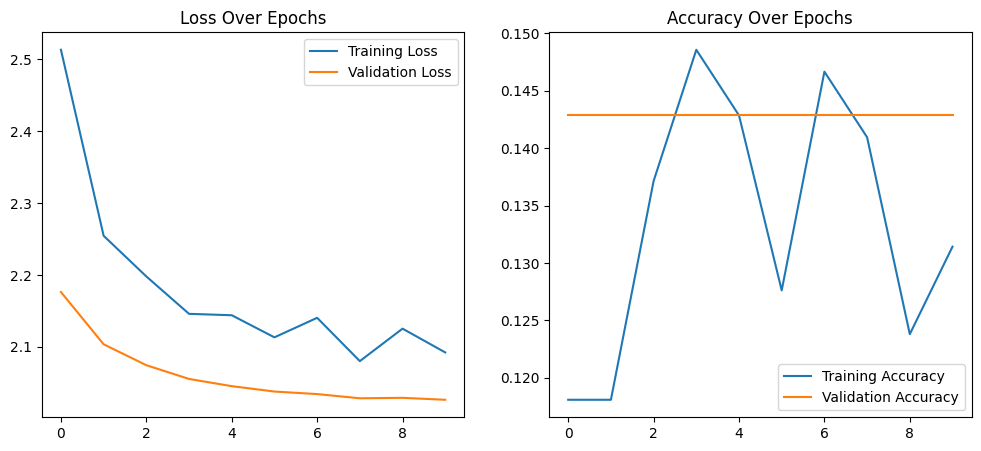

In [46]:
# Augmenting the data
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Data generators for training and validation
train_generator = train_datagen.flow(X_train, y_train, batch_size=20)
validation_generator = train_datagen.flow(X_test_original, y_test_original, batch_size=20)

# Loading InceptionV3 with adjusted input shape for 3-channel images of size 180x180
base_model = InceptionV3(input_shape=(180, 180, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

# Extend the model
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)  # Sigmoid layer for binary classification

# Constructing the final model
model = models.Model(inputs=base_model.input, outputs=x)

# Compiling the model
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
inc_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=10,
    epochs=10,
    verbose=1
)

validation_generator.reset()
y_pred_prob = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # For multi-class classification, using argmax

for epoch in range(10):
    print(f"Epoch {epoch+1}, Training Accuracy: {history.history['accuracy'][epoch]}, Validation Accuracy: {history.history['val_accuracy'][epoch]}")

# Classification report
print(classification_report(y_test_original, y_pred_classes))

# Confusion matrix to calculating sensitivity and specificity for each class
cm = confusion_matrix(y_test_original, y_pred_classes)
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# visualizing the loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()